# Group Project: Student AI Usage Analysis and Classification

## Goal Briefing:

The dataset captures interaction-level features such as academic level, discipline, task type, session duration, number of prompts, perceived AI assistance, satisfaction rating, and whether the student returned to use the AI tool again.

The primary classification task in this project is to predict whether a student will reuse the AI assistant after a session. The target variable is `UsedAgain`, with two possible outcomes: used again or did not use again. Additional regression analysis may be performed to model satisfaction ratings.

Our group will preprocess the dataset, perform feature engineering, and train multiple machine learning models, including linear and tree-based classifiers. Model performance will be evaluated using standard classification metrics such as accuracy and F1-score.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

seed = 42
np.random.seed(seed)


# S1 - Data Loading and Exploration


#### 1. Loading our Data
Load the train data into a pandas DataFrames. Display the first few rows **of each DataFrame** and print the shape of the dataframe.

In [2]:
# Load the Titanic training dataset
df = pd.read_csv("ai_assistant_usage_student_life.csv")

#### 2. Checking for Null Values

Check for null values in the training data.

In [3]:
# Check for null values in the training dataset
print("Number of missing values in each column:")
print(df.isnull().sum())


Number of missing values in each column:
SessionID             0
StudentLevel          0
Discipline            0
SessionDate           0
SessionLengthMin      0
TotalPrompts          0
TaskType              0
AI_AssistanceLevel    0
FinalOutcome          0
UsedAgain             0
SatisfactionRating    0
dtype: int64


#### 3. Checking the class balance

In [4]:
# Calculate class percentages
class_percent = df['UsedAgain'].value_counts(normalize=True) * 100

print("Class distribution (%):")
print(class_percent)



Class distribution (%):
UsedAgain
True     70.64
False    29.36
Name: proportion, dtype: float64


# S2 - Feature Engineering

1. Drop non-unique variables such as `SessionID`, and irrelevant feature such as `SessionDate`.

In [5]:
# Drop non-informative identifiers
cols_to_drop = ['SessionID', 'SessionDate']
df = df.drop(columns=cols_to_drop)

3. Divide `TotalPrompts` with `SessionLengthMin` into a single variable `PromptDensity`. This feature captures how intensively a student interacted with the AI assistant during a session.

In [6]:
#Q2.3
# Create Family feature
df['PromptDensity'] = df['TotalPrompts'] / df['SessionLengthMin']


4. One-hot-encode the features `StudentLevel`, `Discipline`, `FinalOutcome`, and `TaskType`

In [7]:

df = pd.get_dummies(
    df,
    columns=['StudentLevel', 'Discipline', 'TaskType', 'FinalOutcome'],
    drop_first=True
)

5. Correlation Map
Visualize the correlation between variables using a heatmap. List the 3 features that are most related to student AI reusable frequency

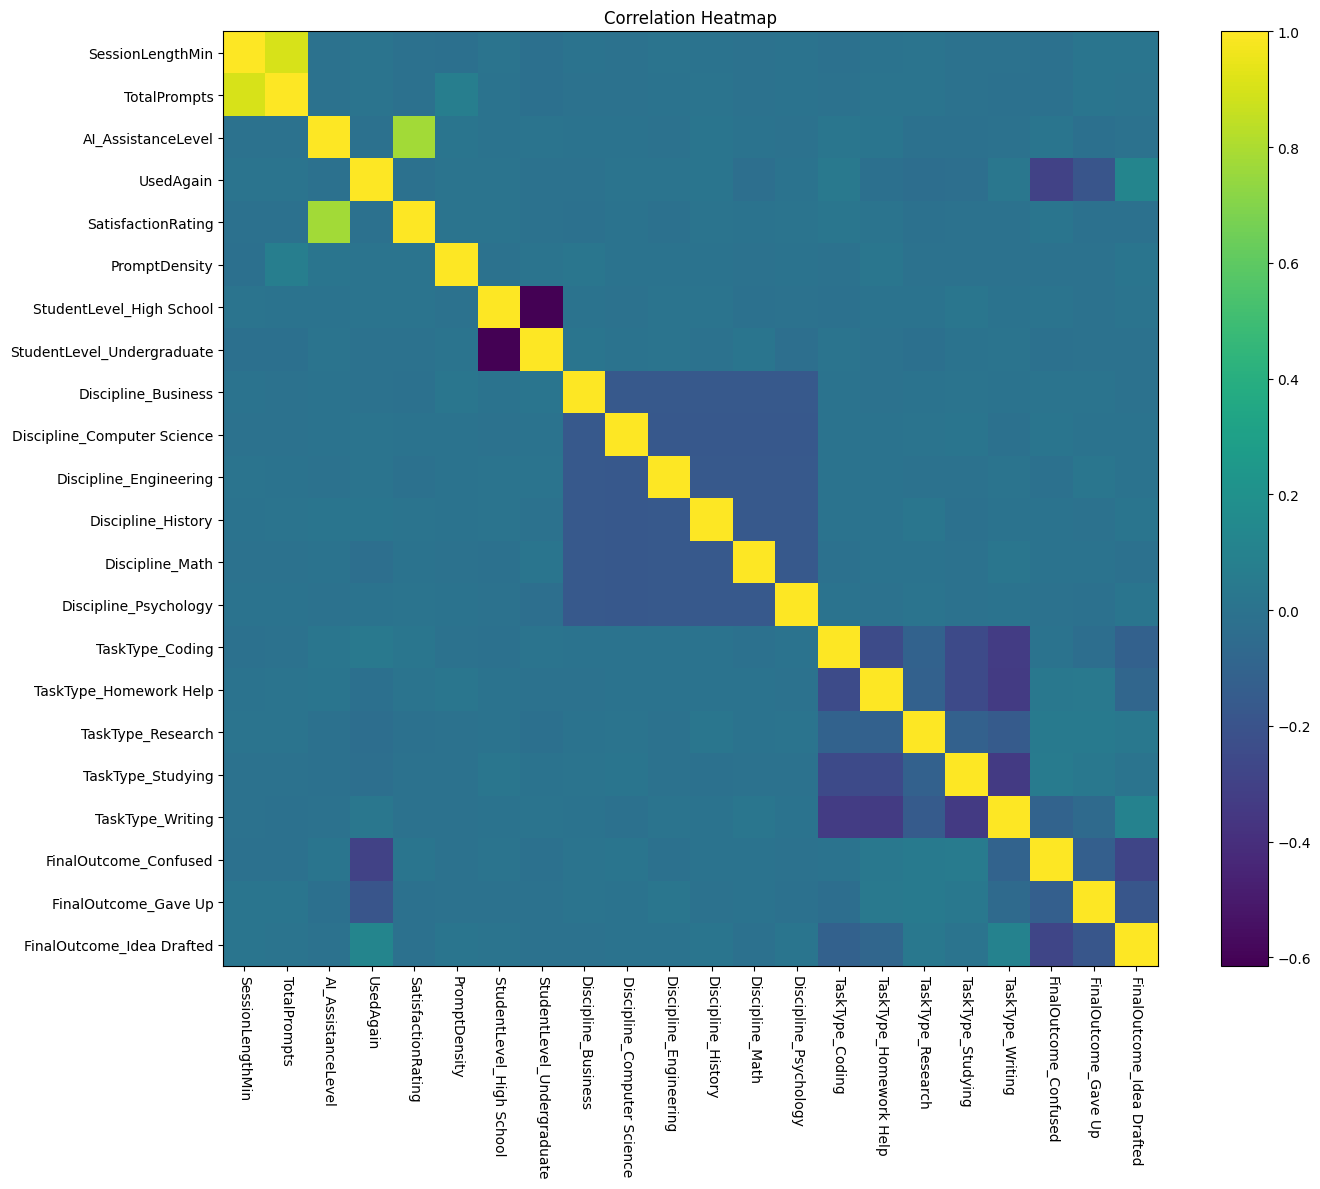

In [8]:
# Compute correlation matrix
corr = df.corr()

# Plot heatmap using matplotlib
plt.figure(figsize=(15, 12))
plt.imshow(corr, interpolation='nearest')
plt.title("Correlation Heatmap")
plt.colorbar()

# Add feature labels
ticks = np.arange(len(corr.columns))
plt.xticks(ticks, corr.columns.tolist(), rotation=270)
plt.yticks(ticks, corr.columns.tolist())

plt.tight_layout()
plt.show()

In [9]:
#List of three features
used_corr = corr['UsedAgain'].abs().sort_values(ascending=False)

top3 = used_corr.iloc[1:4]
print(top3)

FinalOutcome_Confused        0.293381
FinalOutcome_Gave Up         0.187997
FinalOutcome_Idea Drafted    0.117255
Name: UsedAgain, dtype: float64


### Checkpoint

In [10]:
df.head()

,SessionLengthMin,TotalPrompts,AI_AssistanceLevel,UsedAgain,SatisfactionRating,PromptDensity,StudentLevel_High School,StudentLevel_Undergraduate,Discipline_Business,Discipline_Computer Science,...,Discipline_Math,Discipline_Psychology,TaskType_Coding,TaskType_Homework Help,TaskType_Research,TaskType_Studying,TaskType_Writing,FinalOutcome_Confused,FinalOutcome_Gave Up,FinalOutcome_Idea Drafted
0,31.20,11,2,True,1.0,0.352564,False,True,False,True,...,False,False,False,False,False,True,False,False,False,False
1,13.09,6,3,True,2.0,0.458365,False,True,False,False,...,False,True,False,False,False,True,False,False,False,False
2,19.22,5,3,True,3.3,0.260146,False,True,True,False,...,False,False,True,False,False,False,False,False,False,False
3,3.70,1,3,True,3.5,0.270270,False,True,False,True,...,False,False,True,False,False,False,False,False,False,False
4,28.12,9,3,True,2.9,0.320057,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False


# S3 - Train/Test Split and Feature Scaling

#### 1. Scaling
Scale the df. Make sure you do not scale the one-hot-encoded data or the target variable.

In [11]:
df.dtypes

SessionLengthMin               float64
TotalPrompts                     int64
AI_AssistanceLevel               int64
UsedAgain                         bool
SatisfactionRating             float64
PromptDensity                  float64
StudentLevel_High School          bool
StudentLevel_Undergraduate        bool
Discipline_Business               bool
Discipline_Computer Science       bool
Discipline_Engineering            bool
Discipline_History                bool
Discipline_Math                   bool
Discipline_Psychology             bool
TaskType_Coding                   bool
TaskType_Homework Help            bool
TaskType_Research                 bool
TaskType_Studying                 bool
TaskType_Writing                  bool
FinalOutcome_Confused             bool
FinalOutcome_Gave Up              bool
FinalOutcome_Idea Drafted         bool
dtype: object

In [12]:
num_cols = [
    'SessionLengthMin',
    'TotalPrompts',
    'AI_AssistanceLevel',
    'SatisfactionRating',
    'PromptDensity'   
]

# Initialize scaler
scaler = StandardScaler()

# Fit and transform numeric columns
df[num_cols] = scaler.fit_transform(df[num_cols])

# Check first few rows to confirm scaling
print(df.head())

   SessionLengthMin  TotalPrompts  AI_AssistanceLevel  UsedAgain  \
0          0.817000      1.160044           -1.491799       True   
1         -0.486195      0.084435           -0.483486       True   
2         -0.045081     -0.130686           -0.483486       True   
3         -1.161900     -0.991173           -0.483486       True   
4          0.595364      0.729800           -0.483486       True   

   SatisfactionRating  PromptDensity  StudentLevel_High School  \
0           -2.114786       0.181847                     False   
1           -1.240105       0.475965                     False   
2           -0.103020      -0.075069                     False   
3            0.071916      -0.046924                     False   
4           -0.452892       0.091479                     False   

   StudentLevel_Undergraduate  Discipline_Business  \
0                        True                False   
1                        True                False   
2                        True   

#### 2. Train/Test Split
Split the training data into a train and test set using an 80-20 split. Make sure you preserve the balance of the target variable using the `stratify = target` argument.

In [13]:
# Split into train and test sets (80-20), stratifying by the target
X = df.drop(columns=['UsedAgain'])
y = df['UsedAgain']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#### 3. Regression Targets from the Same Split

In [14]:
# Regression targets
y_train_reg = X_train['SatisfactionRating']
y_test_reg = X_test['SatisfactionRating']

# Feature matrices for regression
X_train_reg = X_train.drop(columns=['SatisfactionRating'])
X_test_reg = X_test.drop(columns=['SatisfactionRating'])

#### 4. Check the class balance of the train and test set.
Print the percent of samples that survived in both the train and test set. They should be almost equal since you stratified by the target variable when splitting the data.

In [15]:
print("Train set class distribution (%):")
print(y_train.value_counts(normalize=True) * 100)

print("\nTest set class distribution (%):")
print(y_test.value_counts(normalize=True) * 100)

Train set class distribution (%):
UsedAgain
True     70.6375
False    29.3625
Name: proportion, dtype: float64

Test set class distribution (%):
UsedAgain
True     70.65
False    29.35
Name: proportion, dtype: float64


# S4 - Satisfaction Prediction (Regression)

In this section, we implement supervised regression models to predict student satisfaction with AI-assisted academic sessions. The target variable is `SatisfactionRating`, which ranges from 1 to 5.

#### 1. Instantiate a MultipleLinearRegression model

Multiple Linear Regression is used as a baseline regression model for predicting student satisfaction. As a simple and interpretable model, it allows us to examine the linear relationship between interaction features and satisfaction ratings.

In [16]:
lin_reg = LinearRegression()

#### 2. Train the model on the training data

In [17]:
lin_reg.fit(X_train_reg, y_train_reg)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### 3. Evaluate the model on the test set

Model performance is evaluated on the test set using Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE), which quantify the magnitude of prediction error and provide complementary views of average and large deviations in predicted satisfaction ratings.

In [18]:
# Predict satisfaction ratings on the test set
y_pred_lr = lin_reg.predict(X_test_reg)

# Compute regression error metrics
rmse_lr = np.sqrt(mean_squared_error(y_test_reg, y_pred_lr))
mae_lr = mean_absolute_error(y_test_reg, y_pred_lr)

# Display results
print("Linear Regression Results")
print(f"RMSE: {rmse_lr:.3f}")
print(f"MAE: {mae_lr:.3f}")


Linear Regression Results
RMSE: 0.614
MAE: 0.482


#### 4. Predicted vs Actual Satisfaction Plot

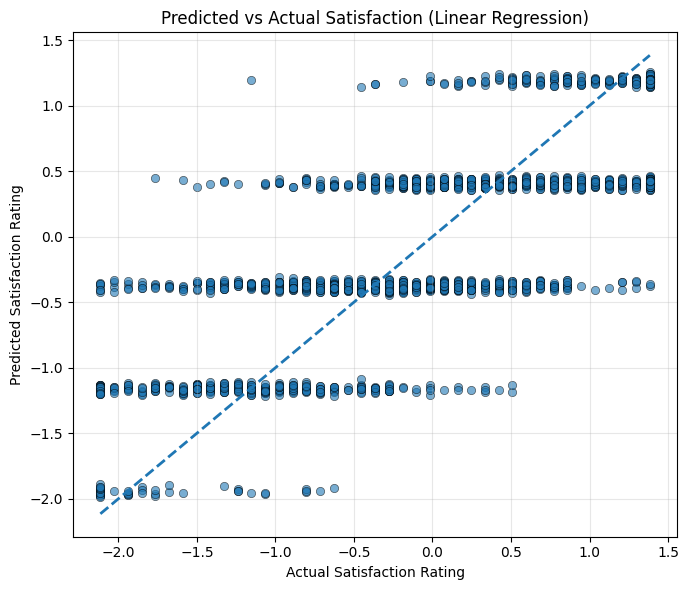

In [19]:
# Plot predicted vs actual satisfaction ratings
plt.figure(figsize=(7, 6))
plt.scatter(
    y_test_reg,
    y_pred_lr,
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5,
    marker='o'
)

# Reference line for perfect predictions
min_val = min(y_test_reg.min(), y_pred_lr.min())
max_val = max(y_test_reg.max(), y_pred_lr.max())
plt.plot([min_val, max_val], [min_val, max_val],
         linestyle='--', linewidth=2)

# Plot formatting
plt.xlabel('Actual Satisfaction Rating')
plt.ylabel('Predicted Satisfaction Rating')
plt.title('Predicted vs Actual Satisfaction (Linear Regression)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#### 5. Instantiate a RandomForestRegressor model

The Random Forest Regressor captures non-linear relationships between session features and satisfaction ratings.

In [20]:
rf_reg = RandomForestRegressor(
    n_estimators=200, # number of trees in the forest
    max_depth=10, # maximum depth of each tree
    min_samples_leaf=5, # minimum samples required at each leaf node
    random_state=42
)

#### 6. Train the model on the training data

In [21]:
rf_reg.fit(X_train_reg, y_train_reg)

,n_estimators,200
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### 7. Evaluate the model on the test set

In [22]:
# Predict satisfaction ratings on the test set
y_pred_rf = rf_reg.predict(X_test_reg)

# Compute regression error metrics
rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf))
mae_rf = mean_absolute_error(y_test_reg, y_pred_rf)

# Display results
print("Random Forest Regressor Results")
print(f"RMSE: {rmse_rf:.3f}")
print(f"MAE: {mae_rf:.3f}")


Random Forest Regressor Results
RMSE: 0.618
MAE: 0.487


#### 8. Residuals vs Predicted Values Plot

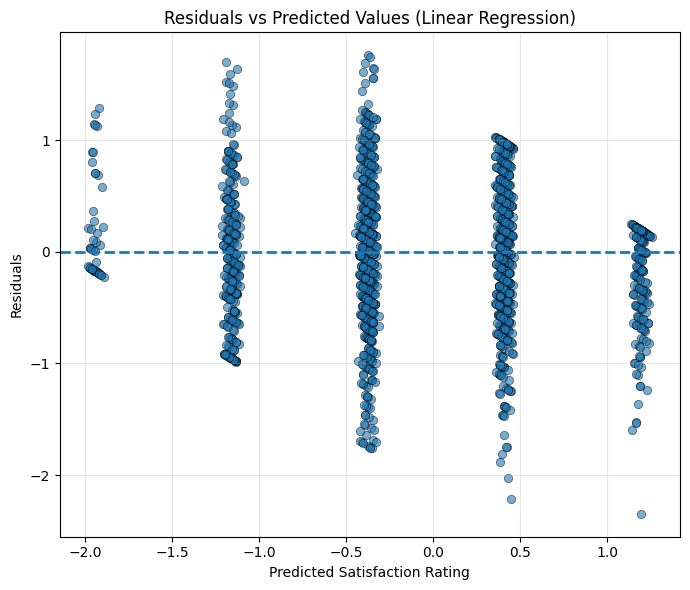

In [23]:
# Compute residuals (actual - predicted values)
residuals_lr = y_test_reg - y_pred_lr

# Plot residuals against predicted values
plt.figure(figsize=(7, 6))
plt.scatter(
    y_pred_lr,
    residuals_lr,
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)

# Reference line at zero residual
plt.axhline(0, linestyle='--', linewidth=2)

# Plot formatting
plt.xlabel('Predicted Satisfaction Rating')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Linear Regression)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Q5 - Classification Models for AI Reuse Prediction

Train and evaluate multiple supervised learning models to predict whether a student will reuse the AI assistant `UsedAgain`. All models are trained using the same train/test split and evaluated using accuracy and F1-score to ensure a fair comparison.

#### 1. Instantiate a LogisticRegression model.

Logistic Regression is used as a baseline classifier for the AI reuse prediction task. As a linear model, it provides an interpretable starting point for understanding how interaction features relate to reuse behavior.

In [24]:
log_reg = LogisticRegression(
    max_iter=1000, # maximum number of training iterations
    solver='liblinear', # optimization algorithm
    class_weight='balanced', # handle class imbalance
    random_state=42
)

#### 2. Train the model on the training data

In [25]:
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


#### 3. Evaluate on the validation set.
Model performance is evaluated using accuracy and F1-score, which together account for overall correctness and class-sensitive performance under moderate class imbalance.

In [26]:
# Generate predictions on the test set
y_pred_lr = log_reg.predict(X_test)

# Compute classification performance metrics
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

# Display results
print("Logistic Regression Results")
print(f"Accuracy: {acc_lr:.2%}")
print(f"F1 Score: {f1_lr:.2f}")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Results
Accuracy: 74.25%
F1 Score: 0.82
              precision    recall  f1-score   support

       False       0.58      0.47      0.52       587
        True       0.79      0.86      0.82      1413

    accuracy                           0.74      2000
   macro avg       0.69      0.66      0.67      2000
weighted avg       0.73      0.74      0.73      2000



#### 4. ROC Curve.


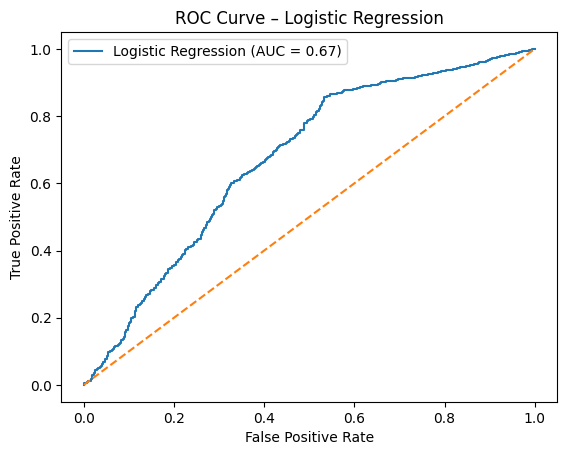

In [27]:
# Compute predicted probabilities for the positive class
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

# Calculate false positive rate, true positive rate, and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression')
plt.legend()
plt.show()

#### 5. Instantiate an RandomForestClassifier model.

The Random Forest classifier is an ensemble learning method that aggregates multiple decision trees to model non-linear relationships in student–AI interaction data.


In [28]:
rf = RandomForestClassifier(
    n_estimators=200, # number of trees in the forest
    max_depth=10, # maximum depth of each tree
    min_samples_leaf=5, # minimum samples required at each leaf node
    class_weight='balanced', # handle class imbalance
    random_state=42
)

#### 6. Train the model on the training data 


In [29]:
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### 7. Evaluate the model on the test set


In [30]:
# Generate predictions on the test set
y_pred_rf = rf.predict(X_test)

# Compute classification performance metrics
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Display results
print("Random Forest Results")
print(f"Accuracy: {acc_rf:.2%}")
print(f"F1 Score: {f1_rf:.2f}")
print(classification_report(y_test, y_pred_rf))


Random Forest Results
Accuracy: 74.30%
F1 Score: 0.83
              precision    recall  f1-score   support

       False       0.58      0.47      0.52       587
        True       0.79      0.86      0.83      1413

    accuracy                           0.74      2000
   macro avg       0.69      0.66      0.67      2000
weighted avg       0.73      0.74      0.73      2000



#### 8. Feature Importance Plot.

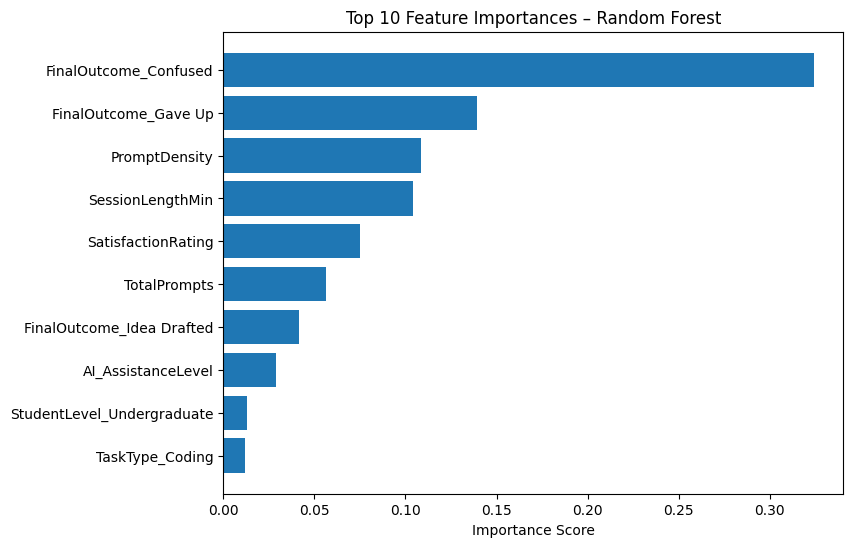

In [31]:
# Extract feature importance scores from the trained Random Forest model
importances = rf.feature_importances_

# Create a DataFrame of features and their importance values
imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 most important features
plt.figure(figsize=(8, 6))
plt.barh(imp_df['Feature'], imp_df['Importance'])
plt.title('Top 10 Feature Importances – Random Forest')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.show()


# Q7 - Model Evaluation & Comparison

#### 1. Regression Models Predictive Performance Comparison
Two regression models were trained to predict student satisfaction ratings:

1. Multiple Linear Regression

2. Random Forest Regressor

Regression models are evaluated using:

1. Root Mean Squared Error (RMSE) – penalizes larger errors more strongly

2. Mean Absolute Error (MAE) – average magnitude of prediction error

Lower values for both metrics indicate better predictive performance.

In [32]:
# Create a summary table for regression model performance
regression_results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest Regressor'],
    'RMSE': [rmse_lr, rmse_rf],
    'MAE': [mae_lr, mae_rf]
})

# Display regression performance metrics
print("Regression Model Performance")
print(regression_results)


Regression Model Performance
                     Model      RMSE       MAE
0        Linear Regression  0.614066  0.481880
1  Random Forest Regressor  0.617711  0.487447


#### 2. Classification Models Classification Performance Comparison
Two classification models were trained to predict whether a student would reuse the AI assistant following an interaction:

1. Logistic Regression

2. Random Forest Classifier

Given the binary nature of the reuse prediction task and the moderate class imbalance (~70% reuse vs. ~30% non-reuse), model performance is evaluated using:

1. Accuracy – overall prediction correctness

2. F1-score – balance between precision and recall

These metrics together provide a robust assessment of classification performance.

In [33]:
# Create a summary table for classification model performance
classification_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest Classifier'],
    'Accuracy': [acc_lr, acc_rf],
    'F1 Score': [f1_lr, f1_rf]
})

# Display classification performance metrics
print("Classification Model Performance")
print(classification_results)


Classification Model Performance
                      Model  Accuracy  F1 Score
0       Logistic Regression    0.7425  0.824651
1  Random Forest Classifier    0.7430  0.825051
